In [1]:
from music21 import *
import os
import random

In [2]:
# # Nathan's musescore path settings
# from music21 import environment
# environLocal = environment.Environment('converter.subConverters')
# environLocal['musescoreDirectPNGPath'] = 'C:\\Program Files\\MuseScore 3\\bin\\MuseScore3.exe'

## Load dataset

In [3]:
DATASET_MAX = 10
dataset_dir = './dataset'
dataset = []
for filename in os.listdir(dataset_dir):
    if filename.endswith('.xml') or filename.endswith('.musicxml'):
        c = converter.parse(dataset_dir + '/' + filename)
        dataset.append(c)
    if len(dataset) >= DATASET_MAX:
        break
print(len(dataset))

10


In [4]:
# transpose each piece to the same key (C or Cm)
def transpose_to_C(s):
    k = s.flatten().getElementsByClass(key.Key).first()
    if k is None:
        k = s.analyze('key')
    i = interval.Interval(k.tonic, pitch.Pitch('C'))
    return s.transpose(i)

dataset_transposed = []
for s in dataset:
    try:
        dataset_transposed.append(transpose_to_C(s))
    except Exception as e:
        print(e)
        pass

print(len(dataset_transposed))

10


## Feature extract

### chords

In [161]:
def hash_chord_symbol(chord_symbol):
    '''
    Input: a chord symbol
    Output: a relevant string, containing features as desired
    ! for now, we output the chordSymbol's root (eg B-)
    '''
    # ! We only hash root, because root and quality (eg B-7) has low sample size
    # return chord_symbol.root().name + chord_symbol.quality
    # return chord_symbol.figure.rstrip('1234567890')
    return  roman.romanNumeralFromChord(chord_symbol, 'C').romanNumeral

def hash_chord_symbol_list(list_chord_symbols):
    '''
    Input: a list of chord symbols
    Output: a hashable object, containing features as desired
    ! for now, we output a tuple with each chordSymbol's figure (eg (B-7, C7))
    '''
    list_hashed = [hash_chord_symbol(symbol) for symbol in list_chord_symbols]
    return tuple(list_hashed)

hash_chord_symbol_list([harmony.ChordSymbol('B-7'), harmony.ChordSymbol('Cmin7')])

('bVII', 'i')

In [162]:
def extract_chords_and_durations (s: stream.Score, include_duration=True):
    '''
    Given a score, with properly notated ChordSymbols,
    returns a list of its hashed chord symbols and durations, 
    eg [(ChordSymbol B-7, 2.0), (ChordSymbol G, 4.0)].
    ! durations are optional
    '''
    chords_and_durs = [] 

    prev_chord_symbol = None
    prev_chord_symbol_offset = 0

    for chord_symbol in s.flatten()[harmony.ChordSymbol]:
        if prev_chord_symbol is not None:
            chord_and_dur = (hash_chord_symbol(prev_chord_symbol), chord_symbol.offset-prev_chord_symbol_offset)
            if include_duration:
                chords_and_durs.append(chord_and_dur)
            else:
                chords_and_durs.append(hash_chord_symbol(prev_chord_symbol))
        prev_chord_symbol = chord_symbol
        prev_chord_symbol_offset = chord_symbol.offset

    return chords_and_durs

### Melody

In [212]:
def hash_note(n: note.Note):
    '''
    Input: a chord symbol
    Output: a relevant hashable object, containing features as desired
    ! for now, we output the note's name and ql as a tuple, for melody gen use later
    '''
    return  (n.name, n.duration.quarterLength)


In [233]:
def extract_notes (s: stream.Score, include_duration=True):
    '''
    Given a score, 
    returns a list of its hashed notes and durations,
    as wel as the current chord.
    '''
    notes = [] 
    current_rn = 'I' # TODO is this good initialization?

    for thing in s.flatten():
        if isinstance(thing, harmony.ChordSymbol):
            chord_symbol = thing
            current_rn =   roman.romanNumeralFromChord(chord_symbol, 'C').romanNumeral
        elif isinstance(thing, note.Note):
            n = thing
            # add rn to the tuple
            notes.append( (hash_note(n),current_rn) )

    return notes

In [263]:
s = dataset_transposed[1]
print(extract_notes(s)[:4])

[(('D', 0.5), 'IV'), (('D', 0.5), 'IV'), (('E', 0.5), 'IV'), (('B', 0.5), 'IV')]


## (Old) hashing stuff

In [46]:
def hash_rhythm(rhythm):
    '''
    Input: list (e.g. [{measure: 0, beat: 0}, {measure: 1, beat: 3}, {measure: 2, beat: 0}])
    Output: string (e.g. 'M1B0-M1B3-M2B0')
    '''
    hashes = []
    for r in rhythm:
        hashes.append(
            'M' + str(r['measure']) + 'B' + str(r['beat'])
        )
    return '-'.join(hashes)

hash_rhythm([{'measure': 0, 'beat': 0}, {'measure': 1, 'beat': 3}, {'measure': 2, 'beat': 0}])

'M0B0-M1B3-M2B0'

In [47]:
def unhash_rhythm(rhythm_hash):
    '''
    Input: a hashed rhythm
    Output: the unhashed rhythm
    '''
    unhashed = []
    for subhash in rhythm_hash.split('-'):
        m, b = subhash[1:].split('B')
        unhashed.append({
            'measure': m,
            'beat': b
        })
    return unhashed
        
unhash_rhythm('M0B0-M1B3-M2B0')

[{'measure': '0', 'beat': '0'},
 {'measure': '1', 'beat': '3'},
 {'measure': '2', 'beat': '0'}]

In [138]:
def generate_progression(pairs):
    '''
    Inputs:
        list of tuples (progression, rhythm) where progression is a tuple of chord names (e.g. ('ii', 'V', 'I'))
            and rhythm is defined above (unhashed)
    Outputs:
        a tuple (progression, rhythm, rhythm_choosing_func)
    '''
    progs = []
    rhythms_given_prog_len = {}
    for prog, rhythm in pairs:
        progs.append(prog)
        if len(prog) not in rhythms_given_prog_len:
            rhythms_given_prog_len[len(prog)] = []
        rhythms_given_prog_len[len(prog)].append(rhythm)
        
    def choose_rhythm(prog):
        return random.choice(rhythms_given_prog_len[len(prog)])
    
    prog = random.choice(progs)
    rhythm = choose_rhythm(prog)
    return prog, rhythm, choose_rhythm

prog = generate_progression([
    (('ii', 'V', 'I'), [{'measure': 0, 'beat': 0}, {'measure': 1, 'beat': 3}, {'measure': 2, 'beat': 0}]),
    (('ii', 'V', 'I'), [{'measure': 0, 'beat': 0}, {'measure': 1, 'beat': 0}, {'measure': 2, 'beat': 0}]),
    (('I', 'V'), [{'measure': 0, 'beat': 0}, {'measure': 2, 'beat': 2}]),
    (('I', 'V7'), [{'measure': 0, 'beat': 0}, {'measure': 2, 'beat': 0}]),
])
prog

(('I', 'V'),
 [{'measure': 0, 'beat': 0}, {'measure': 2, 'beat': 2}],
 <function __main__.generate_progression.<locals>.choose_rhythm(prog)>)

## Generate chords

## prep the markov matrix

In [165]:
from collections import Counter
from more_itertools import windowed

def chord_progression_markov_dict(scores):
    markov_dict = dict()

    for s in scores:
        chords_and_durations = extract_chords_and_durations (s, include_duration=False)
        for window in windowed(chords_and_durations, 3):
            dict_key = window[:-1]
            dict_val = window[-1]
            if dict_key not in markov_dict:
                markov_dict[dict_key] = Counter()
            rel_count = markov_dict[dict_key]
            rel_count[dict_val] += 1

    return(markov_dict)


In [265]:
markov_chords = chord_progression_markov_dict(dataset_transposed)

In [267]:
markov_chords[('V', 'IV')]

Counter({'V': 4, 'I': 4, 'bIII': 1})

## Generate thru the markov matrix

In [194]:
def init_prog(chord_probs, k=key.Key('C')):
    '''
    Picks a set of two chords, to initialize the prog.
    Many ways to do this, but here's one impl:
    '''
    while True:
        random_start = random.choice(list(chord_probs.keys()))
        if random_start[0] in ('I', 'vi'):
            break
    return list(random_start)


def generate_chords(chord_probs, length=4, k=key.Key('C')):
    '''
    Generate the chords for a melody for a given progression, following the markov chain specified by chord_probs.
    
    chord_probs: dict mapping 2 chords to a counter of chords. 
    '''
    prog = init_prog(chord_probs) 
    while len(prog) < length:
        chord_2, chord_1 = prog[-2], prog[-1]
        
        if (chord_2, chord_1) in chord_probs:
            choices = chord_probs[(chord_2, chord_1)]
            # because choices returns a list
            new_chord_list = random.choices(list(choices.keys()), weights=list(choices.values()))
            new_chord = new_chord_list[0]
        else:
            # Don't get stuck, sample from overall dist
            new_chord = (random.choice(list(choices.keys())))[0]

        prog.append(new_chord)
        
    return prog


def generate_looping_chords (markov_chords, length=4):
    '''
    Generate the chords for a melody for a given progression, following the markov chain specified by chord_probs.
    ! Ensures the chord prog can feasibly loop, by forcing the chord prog to be a looping one.
    chord_probs: dict mapping 2 chords to a counter of chords. 
    '''
    while True:
        chord_prog = generate_chords(markov_chords, length=length+1)
        if chord_prog[0] == chord_prog[-1]:
            break
    # don't return the looped end, for simplicity in repeating
    return chord_prog[:-1]

In [188]:
looping_chords = generate_looping_chords(markov_chords, 4)

In [268]:
print(looping_chords)

['I', 'i', 'IV', 'I']


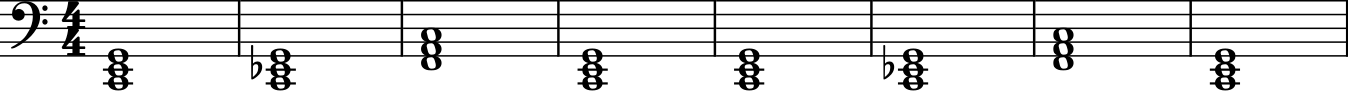

In [279]:
def restify(m):
    def insert_rest(offset, length):
        r = note.Rest()
        r.quarterLength = length
        m.insert(offset, r)
        
    offsets = []
    for o in m:
        offsets.append(o.offset)
        
    offsets = sorted(offsets)
    if len(offsets) == 0:
        insert_rest(0, 4)
        return m
    
    if offsets[0] > 0:
        insert_rest(0, offsets[0])
    
    for i in range(len(offsets)-1):
        insert_rest(offsets[i]+1, offsets[i+1] - (offsets[i] + 1))
        
    if offsets[-1] < 3:
        insert_rest(offsets[-1], 3-offsets[-1])
    
    return m

def generate_chords_part(progression, length, k=key.Key('C')):
    '''
    Generate a Part that is the chord progression repeated for a quarterlength of length.
    '''
    p = stream.Part()
    p.append( clef.BassClef())
    p.append(meter.TimeSignature('4/4'))
    chords, rhythm, _ = progression
    chord_idx = 0
    for i in range(length // 4):
        m = stream.Measure()
        
        measure_idx = i % 4
        for j, symbol in enumerate(chords):
            if rhythm[j]['measure'] == measure_idx:
                # place a chord here
                chrd = roman.RomanNumeral(symbol, k)
                chrd.quarterLength = 4.0
                m.insert(rhythm[j]['beat'], chrd)

                # bring chords down
                chrd.transpose(-24, inPlace=True)

        # restify(m)
        p.append(m)
    
    return p

four_chord_rhythm = [{'measure': 0, 'beat': 0}, {'measure': 1, 'beat': 0},  {'measure': 2, 'beat': 0}, {'measure': 3, 'beat': 0}]
prog = (looping_chords, four_chord_rhythm, 'junk')
p = generate_chords_part(prog, 4*8)
p.show()

## Generate melody
#### Assumes 4/4

In [254]:
from collections import Counter
from more_itertools import windowed
from fractions import Fraction

def melody_markov_dict(scores):
    markov_dict = dict()

    for s in scores:
        notes = extract_notes (s)
        for window in windowed(notes, 3):
            if None not in window:
                (note_1, _) = window[0]
                (note_2, _) = window[1]
                (note_3, key) = window[2]

                if not isinstance(note_3[1], Fraction):

                    dict_key = (note_1, note_2, key)

                    if dict_key not in markov_dict:
                        markov_dict[dict_key] = Counter()
                    rel_count = markov_dict[dict_key]
                    rel_count[note_3] += 1

    return(markov_dict)


In [255]:
melody_matrix = melody_markov_dict(dataset_transposed)

In [257]:
def get_chord_by_offset(progression, offset):
    offset = offset % (4*4)
    measure = offset // 4
    beat = offset - (4*measure)
    
    chords, rhythm, _ = progression
    for i in range(len(chords)):
        if rhythm[i]['measure'] == measure and rhythm[i]['beat'] <= beat:
            return chords[i]
        if rhythm[i]['measure'] > measure:
            return chords[i-1]
        
    return chords[-1]

def init_notes(progression, melody_probs, num_notes, k=key.Key('C')):
    random_start = random.choice(list(melody_probs.keys()))
    return [random_start[0], random_start[1]], 0
    

def get_chord_to_notes(melody_probs):
    c_to_n = {}
    for note_2, note_1, chrd in melody_probs:
        if chrd not in c_to_n:
            c_to_n[chrd] = []
        c_to_n[chrd].append((note_2, note_1, chrd))
    return c_to_n

def generate_melody_notes(progression, melody_probs, length, k=key.Key('C')):
    '''
    Generate a the notes for a melody for a given progression. The length of the part in quarter notes should be 'length'.
    
    melody_probs: dict mapping 2 notes and the current chord to a list of notes. 
                    The 2 notes are supposed to be 2 notes preceeding an offset, and the chord should be the chord that is 
                    being played at that offset.
    '''
    chord_to_notes = get_chord_to_notes(melody_probs)
    # Given current chord and last 2 notes, generate this note
    # note := (pitch, duration); pitch := B3, C4, D#4... r for rests; duration := some number
    # melody_probs := dict[(note, note, chord)] => [note, note, ...]
    notes, offset = init_notes(progression, melody_probs, 2) #[], 0 
    offsets = []
    while offset < length:
        note_2, note_1 = notes[-2], notes[-1]
        chrd = get_chord_by_offset(progression, offset)
        
        if (note_2, note_1, chrd) in melody_probs:
            note_choices = melody_probs[(note_2, note_1, chrd)]
        else:
            if chrd in chord_to_notes:
                chrd_choice = chrd
            else:
                # if the chord never appeared, pick random, as fallback
                chrd_choice = random.choice(list(chord_to_notes.keys()))
            key_ = random.choice(chord_to_notes[chrd_choice])
            note_choices = melody_probs[key_]

        note_0 = random.choices(list(note_choices.keys()), weights=list(note_choices.values()))[0]
        notes.append(note_0)
        offsets.append(offset)
        offset += note_0[1]
        
    melody = [(notes[i+2], offsets[i]) for i in range(len(offsets))]
    return melody

melody_notes = generate_melody_notes(prog, melody_matrix, 4*8)

In [262]:
melody_notes[:4]

[(('E', 0.5), 0), (('A', 0.5), 0.5), (('G', 1.0), 1.0), (('F', 0.5), 2.0)]

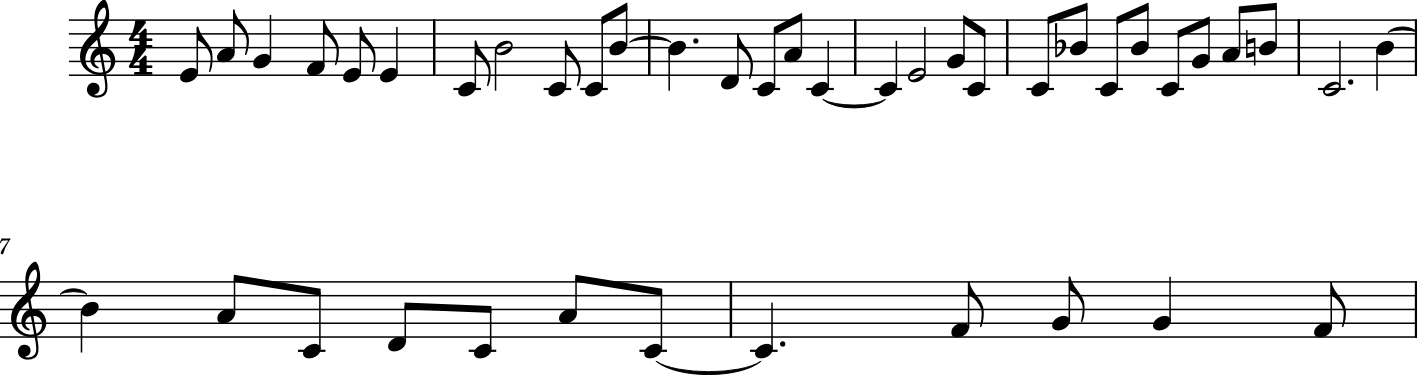

In [259]:
def generate_melody(notes, length):
    '''
    Generate a Part from the melody notes.
    '''
    p = stream.Part()
    p.append(meter.TimeSignature('4/4'))
    
    measure_num = 0
    m = stream.Measure()
    
    for note_def, offset in notes:
        if int(offset // 4) != measure_num:
            for _ in range(int((offset // 4)) - measure_num):
                p.append(m)
                m = stream.Measure()
            measure_num = int(offset // 4)
        
        name, note_len = note_def
        
        if name == 'r':
            n = note.Rest()
        else:
            n = note.Note(name)
        n.quarterLength = note_len
        m.insert(offset % 4, n)
    p.append(m)
    return p



melody = generate_melody(melody_notes, 4*8)
melody.show()

# Big piece

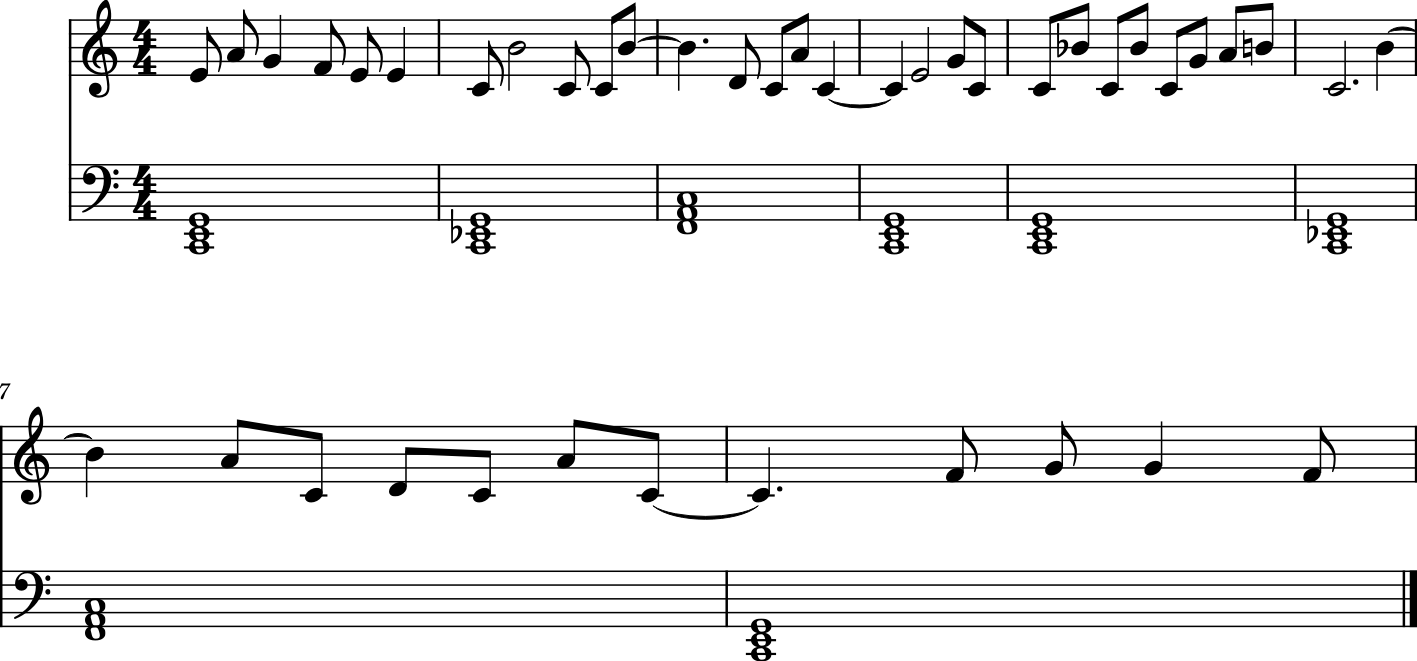

In [280]:
def generate_score(melody, chords):
    score = stream.Score()
    score.append(melody)
    score.append(chords)
    return score

score = generate_score(melody, p)
score.show()

In [288]:
import time
filename = str(int(time.time()))
s.write('musicxml.pdf', filename + '.pdf')
score_midi = score.write('midi', filename + '.midi')